**User Input and Image Generation**

Steps with Gradio:
1. Ask User for Image Concepts: Use Gradio to create a text input interface where users can enter their image concepts.
2. Clean User Input: Ensure the prompt is clean of unnecessary spaces or characters.
3. Prompt the Image Generation Agent: Call APIs to generate images using Stable Diffusion XL and DALL-E based on user input.

In [2]:
# Import Dependencies

# For environment variables
import os
from dotenv import load_dotenv

#For dataframes
import pandas as pd

# For API calls
import requests
import openai

# For image processing and viewing
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# For UI
import gradio as gr

# For caption generation
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load dependencies to measure text output
import nltk
from rouge_score import rouge_scorer

# BLEU Score
from nltk.translate.bleu_score import sentence_bleu

import numpy as np
from sklearn.cluster import KMeans



In [3]:
# Load environment variables.
load_dotenv()

# Store the API key in a variable.
openai.api_key = os.getenv("OPENAI_API_KEY")
STABILITY_AI_API_KEY = os.getenv("STABILITY_AI_API_KEY")

# Set the model name for our LLMs.
OPENAI_MODEL = "gpt-3.5-turbo"

In [4]:
# Utility to view images for debugging
def view_base64_image(base64_string):
    """Decodes a base64 encoded image and displays it using matplotlib."""

    # Decode the base64 string
    image_data = base64.b64decode(base64_string)

    # Open the image using PIL
    image = Image.open(io.BytesIO(image_data))

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
# Utility to clean user input by removing extra spaces
def clean_user_input(user_query):
    cleaned_query = ' '.join(user_query.split())
    return cleaned_query

In [6]:
# Call Stability AI API and generate an image
def generate_stability_ai_image(prompt):
    host = 'https://api.stability.ai/v2beta/stable-image/generate/sd3'
    params = {
        "prompt" : prompt,
        "negative_prompt" : '',
        "aspect_ratio" : '1:1',
        "seed" : 0,
        "output_format" : 'jpeg',
        "model" : "sd3",
        "mode" : "text-to-image"
    }
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_AI_API_KEY}"
    }

    # Encode parameters
    files = {}
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return base64.b64encode(response.content)
    # To test the function: response = generate_stability_ai_image("cute shiba inu")


In [7]:
# Call Dall-E Open AI API and generate an image
def call_dalle_api(prompt):
    client = openai.OpenAI()
    response = client.images.generate(
    model="dall-e-2",
    prompt=prompt,
    size="512x512",
    quality="standard",
    n=1,
    response_format="b64_json"
    )

    return response.data[0].b64_json
    # To test the function: response = call_dalle_api("A realistic image of a shiba inu with a birthday hat on the street")

In [8]:
# Convert base64 string to a PIL Image object
def base64_to_pil_image(base64_string):

    # Decode the base64 string
    image_data = base64.b64decode(base64_string)

    # Create a BytesIO object from the decoded data
    image_bytes = BytesIO(image_data)

    # Open the image using PIL
    image = Image.open(image_bytes)

    return image

In [9]:
import hashlib

# This hash function is to create a unique id for the prompt
def generate_hash(input_string, algorithm='sha256'):
    """
    Generate a hash for a given string using the specified algorithm.
    
    Parameters:
        input_string (str): The input string to hash.
        algorithm (str): The hashing algorithm to use. Options include 'md5', 'sha1', 'sha256', etc.
        
    Returns:
        str: The hexadecimal representation of the hash.
    """
    # Get the hashing function from hashlib based on the specified algorithm
    hash_function = getattr(hashlib, algorithm)
    
    # Create a hash object and update it with the encoded string
    hash_object = hash_function()
    hash_object.update(input_string.encode('utf-8'))
    
    # Return the hexadecimal digest of the hash
    return hash_object.hexdigest()


In [10]:
# Generate images and assess their quality
def generate_images_with_quality(prompt):
    unique_id = generate_hash(prompt, algorithm='md5')

    cleaned_prompt = clean_user_input(prompt)
    stability_ai_image = base64_to_pil_image(generate_stability_ai_image(cleaned_prompt))
    dalle_image = base64_to_pil_image(call_dalle_api(cleaned_prompt))
        
    with open(f"generated_images/{unique_id}_prompt.txt", "w") as f:
        # Write text to the file
        f.write(f'{prompt}, {cleaned_prompt}')
        
    stability_ai_image.save(f'generated_images/{unique_id}_stability_ai.jpg')
    dalle_image.save(f'generated_images/{unique_id}_dalle.jpg')

    #sd_quality = assess_image_quality(sd_image)
    #dalle_quality = assess_image_quality(dalle_image)
    return stability_ai_image, dalle_image #, f"Quality: {sd_quality}", dalle_image, f"Quality: {dalle_quality}"

In [11]:
# Produce output
def create_image_record(prompt, user_preference):
    unique_id = generate_hash(prompt, algorithm='md5')        
    file_output = open('image_generation_results.csv', 'a')
    file_output.write(f'"{unique_id}","{prompt}","","","","","","","{user_preference}"\r\n')
    file_output.close()

In [12]:
def prefer_stability_ai(param):
    create_image_record(param, 'stability_ai')

def prefer_dalle(param):
    create_image_record(param, 'dall-e')

# Create the Gradio interface using Blocks
with gr.Blocks() as demo:
    gr.Markdown("# Text-to-Image Generation")
    gr.Markdown("Input a prompt to generate images using Stability AI and Dall-E.")

    # Input component for text concept
    concept_input = gr.Textbox(label="Enter Image Prompt", placeholder="Describe the image...")

    # Create a submit button
    generate_button = gr.Button("Generate Images")

    # Output components for displaying images
    stability_output = gr.Image(type="pil", label="Stability AI Image")
    dalle_output = gr.Image(type="pil", label="Dall-E Image")

    stability_ai_button = gr.Button("I like Stability AI image")
    stability_ai_button.click(
        fn=prefer_stability_ai, 
        inputs=[concept_input],
        outputs=[]
    )    

    dalle_button = gr.Button("I like Dall-E image")
    dalle_button.click(
        fn=prefer_dalle, 
        inputs=[concept_input],
        outputs=[]
    )    

    # Button click event to generate images
    generate_button.click(
        fn=generate_images_with_quality, 
        inputs=concept_input, 
        outputs=[stability_output, dalle_output]
    )

# Launch the interface
demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


**Image Evaluation, Relevance Check, and Description Generation**

Steps:
1. Evaluate Image Relevance: Use an LLM to assess whether the generated image is relevant to the prompt.
2. Generate Image Descriptions: Use a classifier to create descriptive summaries of the images.
3. Compare Models: Analyze how each model's output aligns with the user query.

In [13]:
# Load the pre-trained model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

2024-10-29 19:50:20.384529: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Function for caption generation
def generate_caption(image):
    # Process the image and generate a caption
    inputs = processor(images=image, return_tensors="pt")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

In [15]:
current_unique_id = '3aec4c5d17bdf13547ba7fad1751c235'

# Load prompt for images
prompt_file = open(f'generated_images/{current_unique_id}_prompt.txt')
prompt = prompt_file.read().split(',')[1]

In [16]:
# Generate caption for Stability AI image
img = Image.open(f"generated_images/{current_unique_id}_stability_ai.jpg")
stability_ai_caption = generate_caption(img)

/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [17]:
# Generate caption for Dall-E image
img = Image.open(f"generated_images/{current_unique_id}_dalle.jpg")
dalle_caption = generate_caption(img)

In [18]:
# Generate Stability AI BLEU score
# Prompted captions and generated captions
reference_captions = [prompt]
generated_captions = [stability_ai_caption]

# Calculate BLEU scores for each pair of reference and generated captions
bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

# Calculate the average BLEU score
stability_ai_bleu = sum(bleu_scores) / len(bleu_scores)

# Print the average BLEU score
print(f"Average BLEU Score: {stability_ai_bleu:.4f}")

Average BLEU Score: 0.0000


/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [19]:
# Generate Dall-E BLEU score
# Prompted captions and generated captions
reference_captions = [prompt]
generated_captions = [dalle_caption]

# Calculate BLEU scores for each pair of reference and generated captions
bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

# Calculate the average BLEU score
dalle_bleu = sum(bleu_scores) / len(bleu_scores)

# Print the average BLEU score
print(f"Average BLEU Score: {dalle_bleu:.4f}")

Average BLEU Score: 0.0000


In [20]:
# Function to calculate Rouge score
def calculate_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

In [21]:
# Generate Stability AI ROUGE Score
reference_captions = [prompt]
generated_captions = [stability_ai_caption]
for ref, gen in zip(reference_captions, generated_captions):
    stability_ai_rouge_score = calculate_rouge(ref, gen)
    print(f"ROUGE scores for reference: '{ref}' and generated: '{gen}': {stability_ai_rouge_score}")

ROUGE scores for reference: ' chicago skyline during the day' and generated: 'chicago skyline from lake michigan': {'rouge1': Score(precision=0.4, recall=0.4, fmeasure=0.4000000000000001), 'rouge2': Score(precision=0.25, recall=0.25, fmeasure=0.25), 'rougeL': Score(precision=0.4, recall=0.4, fmeasure=0.4000000000000001)}


In [22]:
# Generate Dall-E ROUGE Score
reference_captions = [prompt]
generated_captions = [dalle_caption]
for ref, gen in zip(reference_captions, generated_captions):
    dalle_rouge_score = calculate_rouge(ref, gen)
    print(f"ROUGE scores for reference: '{ref}' and generated: '{gen}': {dalle_rouge_score}")

ROUGE scores for reference: ' chicago skyline during the day' and generated: 'chicago skyline from the air': {'rouge1': Score(precision=0.6, recall=0.6, fmeasure=0.6), 'rouge2': Score(precision=0.25, recall=0.25, fmeasure=0.25), 'rougeL': Score(precision=0.6, recall=0.6, fmeasure=0.6)}


/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Applications/anaconda3/envs/dev/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


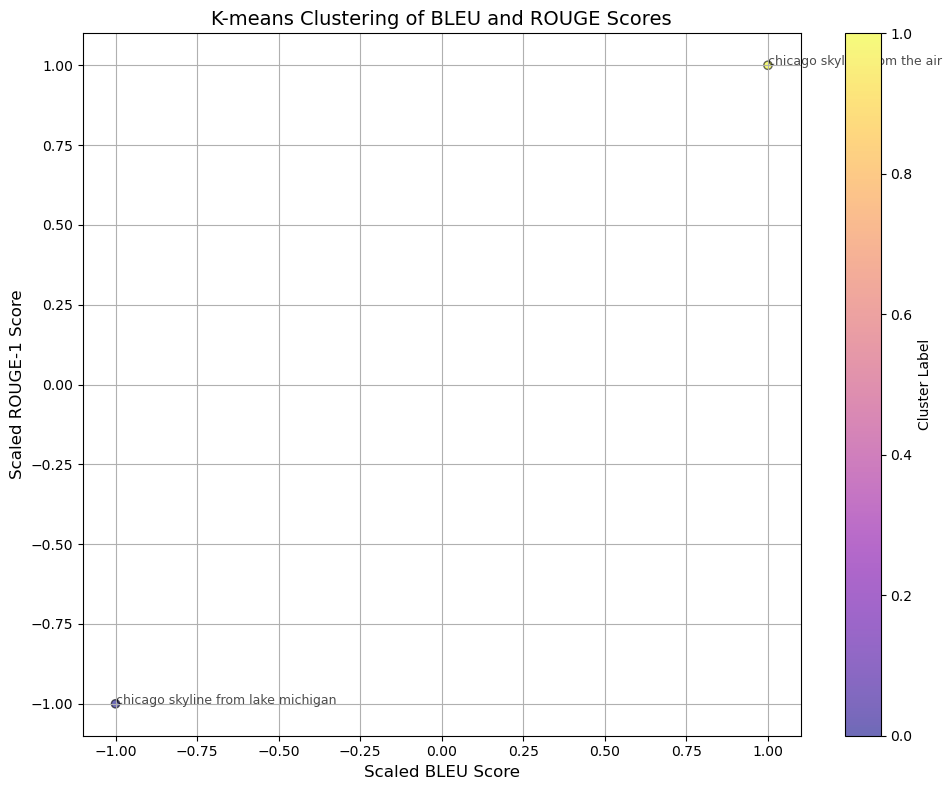

<Figure size 640x480 with 0 Axes>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer



# Sample reference and generated captions
reference_captions = [prompt, prompt]
generated_captions = [stability_ai_caption, dalle_caption]

# Calculate BLEU scores
bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, gen) for ref, gen in zip(reference_captions, generated_captions)]
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]

# Prepare data for K-means
X = np.array(list(zip(bleu_scores, rouge1_scores)))

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)  # Use scaled data
labels = kmeans.labels_

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='plasma', alpha=0.6, edgecolor='k')

# Annotating points
for i, txt in enumerate(generated_captions):
    plt.annotate(txt, (X_scaled[i, 0], X_scaled[i, 1]), fontsize=9, alpha=0.7)

plt.title('K-means Clustering of BLEU and ROUGE Scores', fontsize=14)
plt.xlabel('Scaled BLEU Score', fontsize=12)
plt.ylabel('Scaled ROUGE-1 Score', fontsize=12)
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.tight_layout()

# Show or save the plot
plt.show()  # or plt.savefig('kmeans_clustering_plot.png')
plt.savefig('kmeans_clustering_plot.png')



Output results to file

In [25]:
# Load dataframe
df = pd.read_csv('image_generation_results.csv')

# Get record for prompt
record = df[df["Unique Id"] == current_unique_id]

# Update fields
record["Stability AI Caption"] = stability_ai_caption
record["Dall-E Caption"] = dalle_caption
record["Stability AI BLEU"] = stability_ai_bleu
record["Dall-E BLEU"] = dalle_bleu
record["Stability AI Rouge"] = str(stability_ai_rouge_score)
record["Dall-E Rouge"] = str(dalle_rouge_score)
df[df["Unique Id"] == current_unique_id] = record

# Save back to file
df.to_csv('image_generation_results.csv', index=False)


/var/folders/bp/ghj2hg8n63ngp97nh99m0cr80000gn/T/ipykernel_2910/2517931377.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record["Stability AI Rouge"] = stability_ai_rouge_score
/var/folders/bp/ghj2hg8n63ngp97nh99m0cr80000gn/T/ipykernel_2910/2517931377.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record["Dall-E Rouge"] = dalle_rouge_score


In [26]:
record

,Unique Id,Prompt,Stability AI Caption,Dall-E Caption,Stability AI BLEU,Dall-E BLEU,Stability AI Rouge,Dall-E Rouge,User Preference
rouge1,NaN,NaN,NaN,NaN,NaN,NaN,"(0.4, 0.4, 0.4000000000000001)","(0.6, 0.6, 0.6)",NaN
rouge2,NaN,NaN,NaN,NaN,NaN,NaN,"(0.25, 0.25, 0.25)","(0.25, 0.25, 0.25)",NaN
rougeL,NaN,NaN,NaN,NaN,NaN,NaN,"(0.4, 0.4, 0.4000000000000001)","(0.6, 0.6, 0.6)",NaN


In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load dataframe
df = pd.read_csv('image_generation_results.csv')

# Check for 'User Preference'
if 'User Preference' not in df.columns:
    raise ValueError("User Preference column not found in the DataFrame.")

# Flatten ROUGE score tuples if needed
def flatten_rouge_scores(rouge_column):
    # Check the contents of the column before processing
    print(f"Flattening scores from: {rouge_column}")
    return pd.DataFrame(df[rouge_column].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist(), index=df.index)

# Extract and flatten ROUGE scores
rouge_stability = flatten_rouge_scores('Stability AI Rouge')
rouge_dalle = flatten_rouge_scores('Dall-E Rouge')

# Print shapes of the flattened scores
print(f"Stability AI Rouge shape: {rouge_stability.shape}")
print(f"Dall-E Rouge shape: {rouge_dalle.shape}")

# Ensure we have the correct number of columns
if rouge_stability.shape[1] != 3 or rouge_dalle.shape[1] != 3:
    raise ValueError("Expected 3 columns for ROUGE scores but got different numbers.")

# Add flattened scores back to DataFrame
df[['Stability AI Rouge1', 'Stability AI Rouge2', 'Stability AI RougeL']] = rouge_stability
df[['Dall-E Rouge1', 'Dall-E Rouge2', 'Dall-E RougeL']] = rouge_dalle

# Select features and target variable
features = ['Stability AI Rouge1', 'Stability AI Rouge2', 'Stability AI RougeL',
            'Dall-E Rouge1', 'Dall-E Rouge2', 'Dall-E RougeL',
            'Stability AI BLEU', 'Dall-E BLEU']

# Remove any rows with NaN values
X = df[features].dropna()
y = df.loc[X.index, 'User Preference']

# Check if X and y are empty
if X.empty or y.empty:
    print("No data available for training.")
    print(f"Shape of features: {X.shape}, Shape of target: {y.shape}")
else:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


Flattening scores from: Stability AI Rouge
Flattening scores from: Dall-E Rouge
Stability AI Rouge shape: (4, 1)
Dall-E Rouge shape: (4, 1)


ValueError: Expected 3 columns for ROUGE scores but got different numbers.